# Anime Rating Data Collection

In [1]:
# Author: Avinash Bisram

**Description:** This notebook contains the code used to web scrape the necessary tabular and image data relating to anime. Webscraping was used to collect information on the "Top Anime" from MyAnimeList.com that had aggregate user-ratings of at least 7.5. Tabular data was collected for each show/movie and one or more images were also downloaded for each show (data was collected on April 17th, 2024).

**Output:** The output of this notebook are...
1. anime_data.csv : Tabular data containing information on each anime show/movie
2. image_data.csv : Tabular data containing the respective image URLs for each entry in anime_data.csv (along with their respective score)
3. AnimeImages : Folder of images downloaded from the URLs present in image_data.csv

The above datasets were then uploaded to Kaggle which will be used for the remainder of this research.

In [2]:
# Importing Necessary packages

import requests
from bs4 import BeautifulSoup
import time
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import os

from IPython.display import clear_output
import skimage.io as im

C:\Users\avina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Collection

We want to create two main datasets:
1. A dataset containing tabular data relating to each anime and their respective score on MyAnimeList (tabular data includes genre, demographic, blurb, number of episodes, if the show has a prequel, etc.)
2. A dataset with images relating to each show (if applicable) and the respective score to feed into a CNN

Webscraping Flow:  
1. Base page (https://myanimelist.net/topanime.php?limit=SOMEMULTIPLEOF50)  
    1. Anime name
    2. TV or Movie
    3. Number of episodes
    4. Rating (<-- Our Target)
2. CLICK ON url attached to each name
    1. Blurb / Synopsis
    2. Producers (list)
    3. Studios
    4. Source (manga, light novel, web novel, etc.)
    5. Genres (list)
    6. Demographic
    7. Viewer Discretion Rating
    8. (Optional) Whether or not this show has a prequel
    9. (Optional) If it does have a prequel, what rating does that have right now?
    10. The LINK to the "pictures" tab so we can use it for the second step.

In [4]:
# Generate links to obtain x anime entries

# Specify the number of shows you want to obtain
num_shows = 1867

# Breakpoints
# >= 8.00 num_shows = 638
# >= 7.50 num_shows = 1867
# >= 7.00 num_shows = 4308

# Generating and storing the URLs
base_url = "https://myanimelist.net/topanime.php?limit="
urls = [base_url+str(x) for x in np.arange(0,num_shows,50)]
urls

['https://myanimelist.net/topanime.php?limit=0',
 'https://myanimelist.net/topanime.php?limit=50',
 'https://myanimelist.net/topanime.php?limit=100',
 'https://myanimelist.net/topanime.php?limit=150',
 'https://myanimelist.net/topanime.php?limit=200',
 'https://myanimelist.net/topanime.php?limit=250',
 'https://myanimelist.net/topanime.php?limit=300',
 'https://myanimelist.net/topanime.php?limit=350',
 'https://myanimelist.net/topanime.php?limit=400',
 'https://myanimelist.net/topanime.php?limit=450',
 'https://myanimelist.net/topanime.php?limit=500',
 'https://myanimelist.net/topanime.php?limit=550',
 'https://myanimelist.net/topanime.php?limit=600',
 'https://myanimelist.net/topanime.php?limit=650',
 'https://myanimelist.net/topanime.php?limit=700',
 'https://myanimelist.net/topanime.php?limit=750',
 'https://myanimelist.net/topanime.php?limit=800',
 'https://myanimelist.net/topanime.php?limit=850',
 'https://myanimelist.net/topanime.php?limit=900',
 'https://myanimelist.net/topanime

In [7]:
# Main webscraping code

# Specify the minimum show score you want to have in the dataset
minimum_score = 7.00
end_scrape = False

# Instantiate empty arrays for the different columns of the datasets
anime_names = []
anime_links = []
anime_scores = []
anime_blurbs = []
anime_types = []
anime_episodes = []
anime_statuses = []
anime_producers = []
anime_studios = []
anime_sources = []
anime_genres = []
anime_demographics = []
anime_durations = []
anime_ratings = []

# Main Loop
anime_count = 1

# Break for repeated 405s
notAllowedCount = 0

for url in urls:
    if end_scrape: break
    
    # Clearing the console for extended runs
    clear_output(wait=True)    
    
    # Try connecting to the URL
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error Code: {response.status_code} Link: {url}")
        continue
    else:
        print(f"Connection to {url} success!")
        
    # Adding another longer sleep to work around 405 Not Allowed Error
    time.sleep(300)
        
    # Identify the shows on the page
    soup = BeautifulSoup(response.text, 'html.parser')
    entries = soup.find_all(name = "tr", class_="ranking-list")
    
    # For each entry...
    for entry in entries:
        
        # TEMPORARY BREAK STATEMENT FOR TESTING
        if anime_count > num_shows:
            print(f"Desired show number reached. Breaking...")
            end_scrape = True
            break
        
        print(f"Anime {anime_count}")
        anime_count += 1
        
        # Basic information available in the ranking view
        anime_name = entry.find(name="div", class_ = "di-ib clearfix").text
        anime_link = entry.find(name="a", class_ = "hoverinfo_trigger").attrs['href']
        anime_score = entry.find(name = "td" , class_ = "score ac fs14").text.strip('\n')
        
        # Check if score is below minimum
        if float(anime_score.strip()) < minimum_score:
            print(f"Minimum Score reached. Stopping Scrape at link: {anime_link}. Score: {anime_score.strip()}")
            end_scrape = True
            break
        
        # Fillers in case any fields cannot be found
        anime_blurb = ''
        anime_type = ''
        anime_episode = ''
        anime_status = ''
        anime_producer = ''
        anime_studio = ''
        anime_source = ''
        anime_genre = ''
        anime_demographic = ''
        anime_duration = ''
        anime_rating = ''
        
        # Navigating to each show's MAL page to obtain the rest of the information
        response = requests.get(anime_link)
        
        # Trying to circumvent 405 errors
        time.sleep(random.randint(1,2))
        
        if response.status_code != 200: 
            print(f"Unable to gather additional information for: {anime_name} {anime_link}. Response code: {response.status_code}. Response reason: {response.reason}")            
            if response.status_code == 405:
                notAllowedCount += 1
                if notAllowedCount == 5:
                    print("5 405 errors reached. Ending scrape for now")
                    endScrape = True
                    break
        else:
            small_soup = BeautifulSoup(response.text, 'html.parser')
            
            anime_blurb = small_soup.find(name="p", attrs = {"itemprop" : "description"}).text
            
            # The other fields need to be iterated through
            additional_info = small_soup.find_all(name = "div", class_ = "spaceit_pad")
            #print(f"Size of additional info: {len(additional_info)}")
            
            for div in additional_info:
                text = div.text

                # Anime Type
                if text.find("Type:") == 1: 
                    anime_type = text.replace("\n","").split(":")[1]
                    #print(f"Type: {anime_type}")

                # Number of Episodes
                elif text.find("Episodes:") == 1:
                    anime_episode = text.replace("\n","").split(":")[1].strip()
                    #print(f"Episodes: {anime_episode}")

                # Status
                elif text.find("Status:") == 1:
                    anime_status = text.replace("\n","").split(":")[1].strip()
                    #print(f"Status: {anime_status}")

                # Producers
                elif text.find("Producers:") == 1:
                    anime_producer = ", ".join([producer.strip() for producer in text.replace("\n","").replace("Producers:","").split(",")])
                    #print(f"Producers: {anime_producer}")

                # Studios
                elif text.find("Studios:") == 1:
                    anime_studio = ", ".join([studio.strip() for studio in text[9:].replace("\n","").split(",")])
                    #print(f"Studios: {anime_studio}")

                # Source
                elif text.find("Source:") == 1:
                    anime_source = text.replace("\n","")[7:].strip()
                    #print(f"Source: {anime_source}")

                # Genres (will need additional preprocessing)
                elif text.find("Genres:") == 1:
                    anime_genre = ",".join([genre.strip() for genre in text.replace("\n","")[7:].split(",")])
                    #print(f"Genres: {anime_genre}")

                # Demographic
                elif text.find("Demographic:") == 1:
                    anime_demographic = text.replace("\n","")[12:]
                    #print(f"Demographic: {anime_demographic}")

                # Duration
                elif text.find("Duration:") == 1:
                    anime_duration = text.replace("\n","")[9:].strip()
                    #print(f"Duration: {anime_duration}")

                # Viewer Rating
                elif text.find("Rating:") == 1:
                    anime_rating = text.replace("\n","")[7:].strip()
                    #print(f"Viewer Rating: {anime_rating}")    
            
        # Append all anime-related data to the arrays
        anime_names.append(anime_name)
        anime_links.append(anime_link)
        anime_scores.append(anime_score)
        anime_blurbs.append(anime_blurb)
        anime_types.append(anime_type)
        anime_episodes.append(anime_episode)
        anime_statuses.append(anime_status)
        anime_producers.append(anime_producer)
        anime_studios.append(anime_studio)
        anime_sources.append(anime_source)
        anime_genres.append(anime_genre)
        anime_demographics.append(anime_demographic)
        anime_durations.append(anime_duration)
        anime_ratings.append(anime_rating)

Connection to https://myanimelist.net/topanime.php?limit=1850 success!
Anime 1851
Anime 1852
Anime 1853
Anime 1854
Anime 1855
Anime 1856
Anime 1857
Anime 1858
Anime 1859
Anime 1860
Anime 1861
Anime 1862
Anime 1863
Anime 1864
Anime 1865
Anime 1866
Anime 1867
Desired show number reached. Breaking...


In [8]:
# Combining the webscraping results into a DataFrame

anime_data = pd.DataFrame()
anime_data['Name'] = anime_names
anime_data['Link'] = anime_links
anime_data['Score'] = anime_scores
anime_data['Blurb'] = anime_blurbs
anime_data['Type'] = anime_types
anime_data['Episodes'] = anime_episodes
anime_data['Status'] = anime_statuses
anime_data['Producers'] = anime_producers
anime_data['Studios'] = anime_studios
anime_data['Source'] = anime_sources
anime_data['Genre'] = anime_genres
anime_data['Demographic'] = anime_demographics
anime_data['Duration'] = anime_durations
anime_data['Rating'] = anime_ratings

anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         1867 non-null   object
 1   Link         1867 non-null   object
 2   Score        1867 non-null   object
 3   Blurb        1867 non-null   object
 4   Type         1867 non-null   object
 5   Episodes     1867 non-null   object
 6   Status       1867 non-null   object
 7   Producers    1867 non-null   object
 8   Studios      1867 non-null   object
 9   Source       1867 non-null   object
 10  Genre        1867 non-null   object
 11  Demographic  1867 non-null   object
 12  Duration     1867 non-null   object
 13  Rating       1867 non-null   object
dtypes: object(14)
memory usage: 204.3+ KB


In [9]:
pd.set_option('display.max_columns', None)

anime_data

,Name,Link,Score,Blurb,Type,Episodes,Status,Producers,Studios,Source,Genre,Demographic,Duration,Rating
0,Sousou no Frieren,https://myanimelist.net/anime/52991/Sousou_no_...,9.39,During their decade-long quest to defeat the D...,TV,28,Finished Airing,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,"AdventureAdventure,DramaDrama,FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,9.09,After a horrific alchemy experiment goes wrong...,TV,64,Finished Airing,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,"ActionAction,AdventureAdventure,DramaDrama,Fan...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,TV,24,Finished Airing,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,"DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",,24 min. per ep.,PG-13 - Teens 13 or older
3,Gintama°,https://myanimelist.net/anime/28977/Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",TV,51,Finished Airing,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
4,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,9.05,Seeking to restore humanity's diminishing hope...,TV,10,Finished Airing,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,"ActionAction,DramaDrama,SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,Macross Zero,https://myanimelist.net/anime/194/Macross_Zero,7.50,Taking place one year before the Zentraedi arr...,OVA,5,Finished Airing,"Bandai Visual, Big West",Satelight,Original,"ActionAction,AdventureAdventure,Sci-FiSci-Fi",,30 min. per ep.,R+ - Mild Nudity
1863,Meitantei Conan Magic File 2: Kudou Shinichi N...,https://myanimelist.net/anime/5348/Meitantei_C...,7.50,Magic File 2 was sold at select retailers (7-1...,OVA,1,Finished Airing,"None found, add some",TMS Entertainment,Manga,"AdventureAdventure,ComedyComedy,MysteryMystery",ShounenShounen,28 min.,PG-13 - Teens 13 or older
1864,Sengoku Basara Ni,https://myanimelist.net/anime/6634/Sengoku_Bas...,7.50,"The deadly confrontation with the Devil King, ...",TV,12,Finished Airing,"Dentsu, Shochiku, Mainichi Broadcasting System...",Production I.G,Game,"ActionAction,FantasyFantasy",,24 min. per ep.,PG-13 - Teens 13 or older
1865,Special A,https://myanimelist.net/anime/3470/Special_A,7.50,Hikari Hanazono has always been able to do thi...,TV,24,Finished Airing,Showgate,"Gonzo, AIC",Manga,"ComedyComedy,RomanceRomance",ShoujoShoujo,24 min. per ep.,PG-13 - Teens 13 or older


In [10]:
# Saving anime data as a CSV

# Only execute the below line if you want to replace data
# anime_data.to_csv('anime_data.csv')

In [11]:
# Writing a helper function to iterate through anime_data and gather the image links for each

image_anime_names = []
image_links = []
image_scores = []

notAllowedCount = 0

def getImageLinks(anime_data):
    
    # For each row in anime_data (each show/movie)
    for i in range(len(anime_data)):       
        
        row = anime_data.iloc[i]
        
        # Save the name, score, and link
        name = row['Name']
        score = row['Score']
        url = row['Link'] + "/pics"
        
        # Navigate to the pictures page
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Connection Failed. {response.status_code}")
            notAllowedCount += 1
            if notAllowedCount == 5:
                print("Error limit reached. Stopping scrape for now.")
                break
        else:
            #print("Connection Successful")

            # Grab the contents of the page
            soup = BeautifulSoup(response.text)

            # Find all image anchors
            images = soup.find_all(name = "a", class_ = "js-picture-gallery")
            
            # For each image, append the link and the score
            for image in images:
                image_links.append(image.attrs['href'])
                image_scores.append(score)
                image_anime_names.append(name)
        
        print(f"{i} : {row['Name']}")
        
        # Adding sleep for 405 avoidance
        if i%50==0:
            time.sleep(300)
            clear_output(wait=True)
    
    print("Done!")

In [12]:
# Calling the function

getImageLinks(anime_data)

1851 : City Hunter: Goodbye My Sweetheart
1852 : D-Frag!
1853 : Da Wang Rao Ming
1854 : Flying Witch
1855 : Ginga Hyouryuu Vifam
1856 : Hello World
1857 : KanColle Movie
1858 : Kappa no Coo to Natsuyasumi
1859 : Lady Jewelpet
1860 : Lord El-Melloi II Sei no Jikenbo: Rail Zeppelin Grace Note Special
1861 : Love Live! Nijigasaki Gakuen School Idol Doukoukai
1862 : Macross Zero
1863 : Meitantei Conan Magic File 2: Kudou Shinichi Nazo no Kabe to Kuro Lab Jiken
1864 : Sengoku Basara Ni
1865 : Special A
1866 : Sugar Sugar Rune
Done!


In [13]:
# Combine into a DataFrame and save

image_data = pd.DataFrame()
image_data['ImageLink'] = image_links
image_data['ImageScore'] = image_scores
image_data['AnimeName'] = image_anime_names

# Save as a CSV for now (Only run the below when you want to replace data)
#image_data.to_csv('image_data.csv')

image_data.info()
image_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9008 entries, 0 to 9007
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ImageLink   9008 non-null   object
 1   ImageScore  9008 non-null   object
 2   AnimeName   9008 non-null   object
dtypes: object(3)
memory usage: 211.2+ KB


,ImageLink,ImageScore,AnimeName
0,https://cdn.myanimelist.net/images/anime/1675/...,9.39,Sousou no Frieren
1,https://cdn.myanimelist.net/images/anime/1218/...,9.39,Sousou no Frieren
2,https://cdn.myanimelist.net/images/anime/1667/...,9.39,Sousou no Frieren
3,https://cdn.myanimelist.net/images/anime/1875/...,9.39,Sousou no Frieren
4,https://cdn.myanimelist.net/images/anime/1553/...,9.39,Sousou no Frieren
...,...,...,...
9003,https://cdn.myanimelist.net/images/anime/5/161...,7.50,Sugar Sugar Rune
9004,https://cdn.myanimelist.net/images/anime/5/747...,7.50,Sugar Sugar Rune
9005,https://cdn.myanimelist.net/images/anime/1147/...,7.50,Sugar Sugar Rune
9006,https://cdn.myanimelist.net/images/anime/1216/...,7.50,Sugar Sugar Rune


In [15]:
# For each image link, attempt to download them and save in AnimeImages

# Each image name corresponds to an index in image_data

invalid_indexes = []
notAllowedCount = 0

for rowNum in range(len(image_data)):
    row = image_data.iloc[rowNum]
    
    image_url = row['ImageLink']
    
    # Sleep
    if rowNum>0 and rowNum%300==0:
        time.sleep(300)
        clear_output(wait=True)
        
    try:
        response = requests.get(image_url)
    except:
        invalid_indexes.append(rowNum)
        continue
        
    if response.status_code != 200:
        print(f"Error {response.status_code} at image_data index {rowNum}")
        invalid_indexes.append(rowNum)
        notAllowedCount += 1
        if notAllowedCount == 5:
            print("NotAllowedCount limit reached. Stopping scrape for now.")
            break
    else:
        image = Image.open(BytesIO(response.content))
        image_name = str(rowNum)+".jpg"
        # image.save("AnimeImages/"+image_name) # Only uncomment to replace data
        print(image_name)
    
print("Done!")

9000.jpg
9001.jpg
9002.jpg
9003.jpg
9004.jpg
9005.jpg
9006.jpg
9007.jpg
Done!


In [17]:
# Displaying the invalid indexes

invalid_indexes

# Only one link that has an issue

[]

In [21]:
# Confirming the number of images downloaded

len(os.listdir('AnimeImages')[1:])

9008

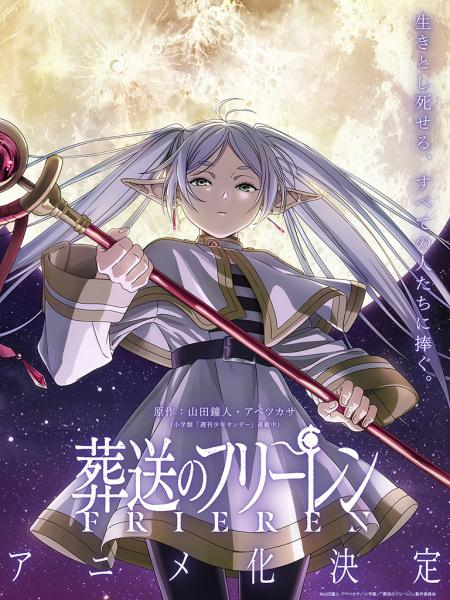

In [18]:
# Viewing a few images in the folder

image_names = os.listdir('AnimeImages')[1:]

test_image = Image.open("AnimeImages/" + image_names[0])
test_image

After the data collection process, we should have three groups of data...
1. anime_data.csv : Tabular data containing information on each anime show/movie
2. image_data.csv : Tabular data containing the respective image URLs for each entry in anime_data.csv (along with their respective score)
3. AnimeImages : Folder of images downloaded from the URLs present in image_data.csv